In [1]:
import json
import emoji
import sys
import re
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
import preprocessing
train_padded, validation_padded, training_label, validation_label = preprocessing.main()

print(train_padded.shape)
print(validation_padded.shape)

(13525, 50)
(3382, 50)


In [15]:
vocab_size = 18000
max_length = 50

In [19]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [17]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model2.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=0.0006), metrics=['acc'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           2304000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 2,445,140
Trainable params: 2,445,140
Non-trainable params: 0
____________________________________________

Train on 13525 samples, validate on 3382 samples
Epoch 1/5
13525/13525 - 100s - loss: 0.7930 - acc: 0.6903 - val_loss: 0.6556 - val_acc: 0.7339
Epoch 2/5
13525/13525 - 78s - loss: 0.6030 - acc: 0.7580 - val_loss: 0.5772 - val_acc: 0.7850
Epoch 3/5
13525/13525 - 78s - loss: 0.4951 - acc: 0.8226 - val_loss: 0.5450 - val_acc: 0.7975
Epoch 4/5
13525/13525 - 78s - loss: 0.4042 - acc: 0.8606 - val_loss: 0.5233 - val_acc: 0.7989
Epoch 5/5
13525/13525 - 78s - loss: 0.3500 - acc: 0.8776 - val_loss: 0.4863 - val_acc: 0.8187


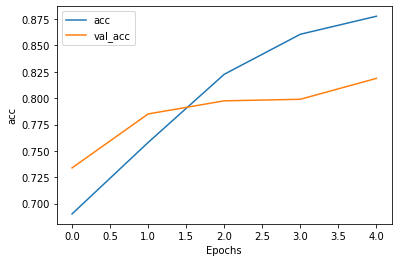

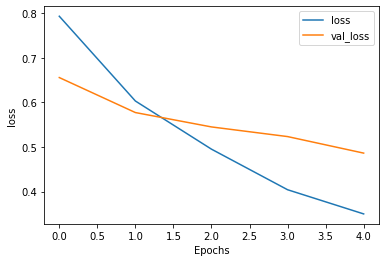

In [18]:
num_epochs = 5
history2 = model2.fit(train_padded, training_label, epochs = num_epochs, validation_data=(validation_padded, validation_label), verbose = 2)
plot_graphs(history2, "acc")
plot_graphs(history2, "loss")